In [1]:
from datasets import load_dataset

train_dataset = load_dataset("json", data_files="dataset_final_results/introduction_train.json")
val_dataset = load_dataset("json", data_files="dataset_final_results/introduction_val.json")
test_dataset = load_dataset("json", data_files="dataset_final_results/introduction_test.json")

Generating train split: 0 examples [00:00, ? examples/s]

In [2]:
train_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Monologue', 'Context'],
        num_rows: 40
    })
})

In [3]:
val_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Monologue', 'Context'],
        num_rows: 5
    })
})

In [4]:
test_dataset

DatasetDict({
    train: Dataset({
        features: ['Game', 'Monologue', 'Context'],
        num_rows: 5
    })
})

In [5]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [6]:
def formatting_func(example):
    return f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>{example['Game']}</TITLE>:

<CONTEXT>{example['Context']}</CONTEXT>
    
<TITLE>{example['Game']}</TITLE>'s introductory monologue is as follows:

<MONO>{example['Monologue']}</MONO>

<END>"""


In [7]:
# Explicitly setting the token
import os
os.environ["HF_TOKEN"] = ""

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
config = AutoConfig.from_pretrained("meta-llama/Llama-2-7b-hf")

In [9]:
base_model_id = "meta-llama/Llama-2-7b-hf"

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [11]:
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config,config=config)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [13]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

In [14]:
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt)

45


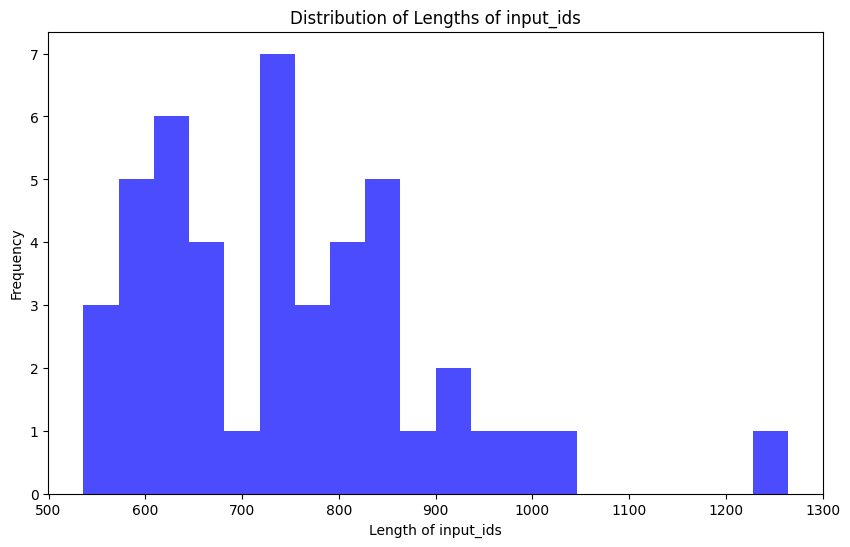

In [15]:
import matplotlib.pyplot as plt


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset['train']]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
import numpy as np

lengths = [len(x['input_ids']) for x in tokenized_train_dataset['train']]

print(f"Mean: {np.mean(lengths)}")

# Calculate the 95th percentile
print(f"95th percentile: {np.percentile(lengths, 95)}")

# Calculate the max length
print(f"Max length: {np.max(lengths)}")

Mean: 747.8
95th percentile: 984.4499999999999
Max length: 1264


In [17]:
max_length = 1264  # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [18]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = val_dataset.map(generate_and_tokenize_prompt2)

45


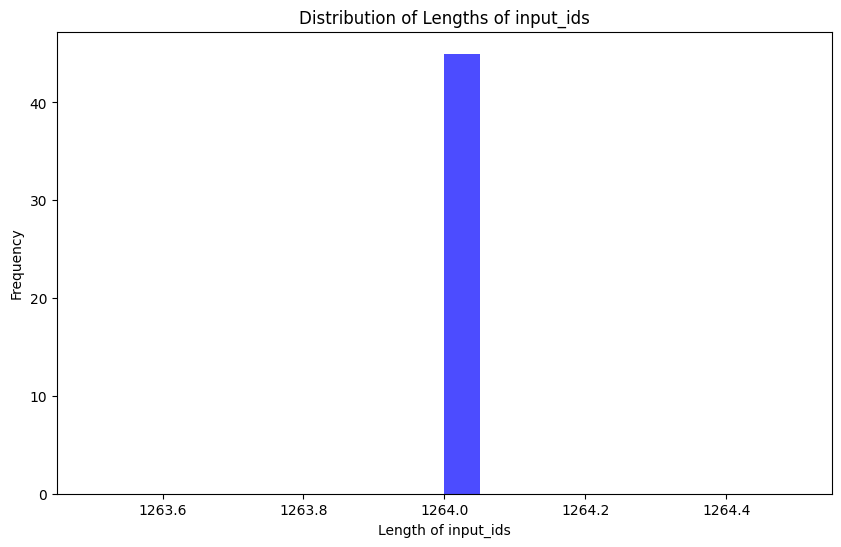

In [19]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [11]:
eval_prompt = (f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing monologue that is based in the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>Elden Ring</TITLE>:

<CONTEXT>In <TITLE>Elden Ring</TITLE>, the introductory monologue delivered by a narrator sets the stage for the game's epic dark fantasy narrative. The player takes on the role of a Tarnished, one of the dead who yet live, called back to the Lands Between to restore the fractured world. The once-great Elden Ring has been shattered, and Queen Marika the Eternal has disappeared. On the Night of the Black Knives, the demigod Godwin the Golden was the first to fall, leading Marika's demigod offspring to seize the shards of the Elden Ring. Their newfound power triggered the Shattering, a catastrophic war that left the Lands Between in chaos and abandoned by the Greater Will. The Tarnished, including chieftains, sorcerers, and other notable figures, are beckoned by the call of long-lost grace to reclaim their destiny. As a Tarnished of no renown, the player must cross the fog to the Lands Between, face formidable foes, and seek to reunite the Elden Ring, ultimately striving to become the Elden Lord. The game explores themes of power, legacy, and redemption in a richly detailed and mysterious world.</CONTEXT>
    
<TITLE>Elden Ring</TITLE>'s introductory monologue is as follows:
<END>

Please remember to generate the introductory monologue based on the given context. The monologue should be relatively large and feel like a natural introduction to the game world described in the context. The monologue should not start by addressing the player directly and should not contain the name of the game.

Generated monologue:
""")

In [12]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.15)[0],
                                skip_special_tokens=True))

NameError: name 'model' is not defined

In [21]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [22]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [23]:
print(model)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Lla

In [24]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj,"
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    use_rslora=True,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 128974848 || all params: 3629387776 || trainable%: 3.5536254586206


In [25]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linear4

In [26]:
if torch.cuda.device_count() > 1:  # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [27]:
model = accelerator.prepare_model(model)

In [28]:
import transformers

project = "Monologue-finetune"
base_model_name = "llama2"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset["train"],
    eval_dataset=tokenized_val_dataset["train"],
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=280,
        learning_rate=5.5e-6,  # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=10,  # When to start reporting loss
        logging_dir="./logs",  # Directory for storing logs
        save_strategy="steps",  # Save the model checkpoint every logging step
        save_steps=10,  # Save checkpoints every 50 steps
        evaluation_strategy="steps",  # Evaluate the model every logging step
        eval_steps=10,  # Evaluate and save checkpoints every 50 steps


    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
C:\Users\Pumukl\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two va

Step,Training Loss,Validation Loss
10,1.691600,1.660724


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


Step,Training Loss,Validation Loss
10,1.691600,1.660724
20,1.547700,1.566546
30,1.486100,1.482319
40,1.364900,1.410405
50,1.261300,1.326472
60,1.261400,1.228579
70,1.139200,1.141921
80,0.938900,1.087079
90,0.856700,1.057011
100,1.061000,1.039343


TrainOutput(global_step=280, training_loss=0.9874170337404523, metrics={'train_runtime': 1536.9241, 'train_samples_per_second': 0.182, 'train_steps_per_second': 0.182, 'total_flos': 1.430470698467328e+16, 'train_loss': 0.9874170337404523, 'epoch': 7.0})

In [16]:
#generate the diagrams for the training
import pandas as pd
import matplotlib.pyplot as plt

# Load from the output_dir the last checkpoints trainer state, validation loss and training loss
df = pd.read_json(output_dir + "/checkpoint-280/trainer_state.json")

df = df['log_history']

# conbine the dictionaries of every two rows
df = pd.DataFrame([{**df[i], **df[i + 1]} for i in range(0, len(df), 2)])

# keep only the step, training loss and validation loss columns
df = df[['step', 'loss', 'eval_loss']]

df

,step,loss,eval_loss
0,10,1.6916,1.660724
1,20,1.5477,1.566546
2,30,1.4861,1.482319
3,40,1.3649,1.410405
4,50,1.2613,1.326472
5,60,1.2614,1.228579
6,70,1.1392,1.141921
7,80,0.9389,1.087079
8,90,0.8567,1.057011
9,100,1.0610,1.039343


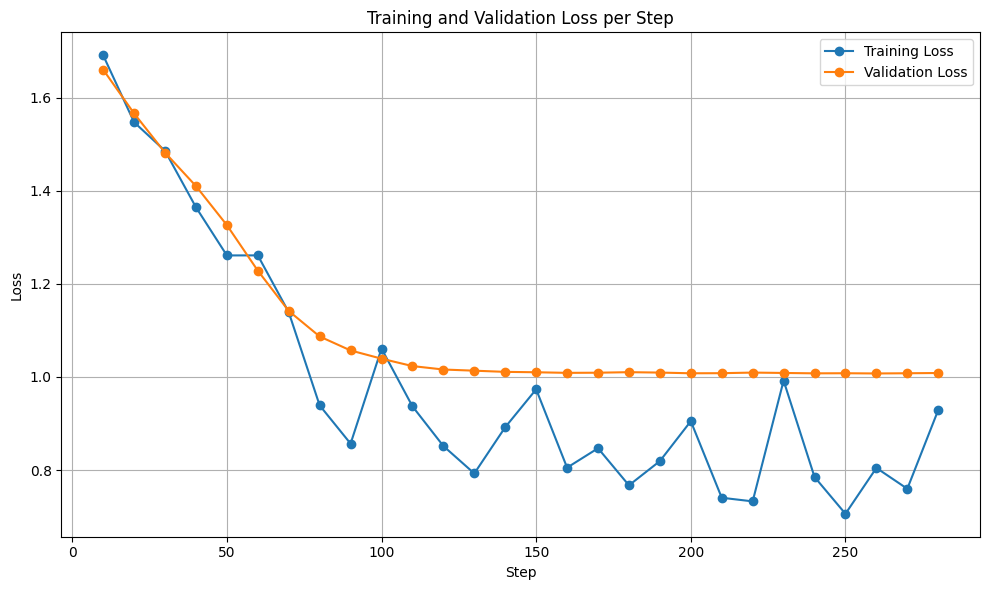

In [17]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df["step"], df["loss"], label='Training Loss', marker='o')
plt.plot(df["step"], df["eval_loss"], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "llama2-Monologue-finetune/checkpoint-200")

In [68]:
eval_prompt = (f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>Elden Ring</TITLE>:

<CONTEXT>In <TITLE>Elden Ring</TITLE>, the introductory monologue delivered by a narrator sets the stage for the game's epic dark fantasy narrative. The player takes on the role of a Tarnished, one of the dead who yet live, called back to the Lands Between to restore the fractured world. The once-great Elden Ring has been shattered, and Queen Marika the Eternal has disappeared. On the Night of the Black Knives, the demigod Godwin the Golden was the first to fall, leading Marika's demigod offspring to seize the shards of the Elden Ring. Their newfound power triggered the Shattering, a catastrophic war that left the Lands Between in chaos and abandoned by the Greater Will. The Tarnished, including chieftains, sorcerers, and other notable figures, are beckoned by the call of long-lost grace to reclaim their destiny. As a Tarnished of no renown, the player must cross the fog to the Lands Between, face formidable foes, and seek to reunite the Elden Ring, ultimately striving to become the Elden Lord. The game explores themes of power, legacy, and redemption in a richly detailed and mysterious world.</CONTEXT>
    
<TITLE>Elden Ring</TITLE>'s introductory monologue is as follows:

<END>

Please remember to generate the introductory monologue.

The generated introductory monologue should be plain text without any special characters or tags.

The generated introductory monologue should be large 

The introductory monologue should not start by addressing the player directly and should not contain the name of the game.

Do not use the line "Welcome traveler" or its abbreviations as the first line of the monologue.

The generated introductory monologue should feel like a natural introduction to the game world described in the context.

Generated monologue:
"""
)
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.25, temperature=0.3, top_p=0.6)[0],
                                skip_special_tokens=True))


In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>. Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the gam

In [259]:
def evaluation_func(example):
    
    return f"""
In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>.Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game called <TITLE>{example['Game']}</TITLE>:

<CONTEXT>{example['Context']}</CONTEXT>
    
<TITLE>{example['Game']}</TITLE>'s introductory monologue is as follows:

<END>

Please remember to generate the introductory monologue.

Generated monologue:

"""

In [260]:
import pandas as pd
 # Create an evaluation data frame for each example in the test dataset
eval_df = pd.DataFrame(test_dataset['train'])
eval_df['description'] = eval_df.apply(evaluation_func, axis=1)

In [261]:
# create a new dataframe from the Dialogue column of the eval_df
test_monologues = eval_df['Monologue']

In [262]:
eval_df = eval_df[['description']]

In [263]:
eval_df

,description
0,"\nIn the following text, there is a descriptio..."
1,"\nIn the following text, there is a descriptio..."
2,"\nIn the following text, there is a descriptio..."
3,"\nIn the following text, there is a descriptio..."
4,"\nIn the following text, there is a descriptio..."


In [257]:
#make the model generate answers for the first monologue in the eval_df
model_input = eval_tokenizer(eval_df['description'][1], return_tensors="pt").to("cuda")
ft_model.eval()
with torch.no_grad():
    answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.25, temperature=0.3, top_p=0.6)[0],
                                skip_special_tokens=True)
    print(answer)


In the following text, there is a description about introductory monologues in a video game. The text will be enclosed within <START> and <END>. There are specific rules that apply only to the text: the title of the current game will always be enclosed inside <TITLE> and </TITLE>, the monologue will always be enclosed inside <MONO> and </MONO>, and the context will be enclosed inside <CONTEXT> and </CONTEXT>.Your task is to generate the missing monologue between the <MONO> and </MONO> tags inside the provided text.

<START>
In video games, sometimes there is an introductory monologue delivered by a narrator. The narrator can either be an unknown narrator or a character that exists within the game, and they introduce the Player to the world, the story, and the setting of the game with the assistance of an introductory monologue. 

This monologue is based on the game's setting, world, story, and the Player's role in the game. Here is some context describing these elements about the game

In [322]:
#for each element in the eval_df, generate an answer from the model
answers = []

In [323]:
 #make the model generate answers for all the dialogues in the eval_df
for i in range(0, len(eval_df)):
    model_input = eval_tokenizer(eval_df['description'][i], return_tensors="pt").to("cuda")
    ft_model.eval()
    with torch.no_grad():
        answer = eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=2000, repetition_penalty=1.25, temperature=0.3, top_p=0.7)[0],
                                skip_special_tokens=True)
        answers.append(answer)

In [324]:
 len(answers)

5

In [325]:
#make the answers into a dataframe
answers_df = pd.DataFrame(answers, columns=['Monologue'])
#export the answers to an excel file
answers_df.to_excel('Llama2_Monologues_Full.xlsx', index=False)

In [298]:
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('Llama2_Monologues_Full.xlsx')
#name the column Dialogue
answers_df.columns = ['Monologue']
answers_df

,Monologue
0,"\nIn the following text, there is a descriptio..."
1,"\nIn the following text, there is a descriptio..."
2,"\nIn the following text, there is a descriptio..."
3,"\nIn the following text, there is a descriptio..."
4,"\nIn the following text, there is a descriptio..."


In [303]:
#for each line in the answers_df, keep only the text after the Answer: tag
answers_df['Monologue'] = answers_df['Monologue'].str.split('Generated monologue:').str[1]

In [304]:
answers_df

,Monologue
0,"\n\n""The age-old art of war has evolved over t..."
1,\n\nThe age before this one began long ago. It...
2,"\n\n""The galaxy has been searching since befor..."
3,\n\nThe wind whispers secrets from beyond deat...
4,"\n\nThe year is 2146, two hundred years after ..."


In [305]:
#export the answers to an excel file
answers_df.to_excel('Llama2_Monologue_Answers_Only.xlsx', index=False)

In [306]:
import pandas as pd
#import the answers from the excel file answes_test.xlsx with a column named Dialogue
answers_df = pd.read_excel('Llama2_Monologue_Answers_Only2.xlsx')
#name the column Dialogue
answers_df.columns = ['Monologue']

In [307]:
#convert everything in the answers_df to a string
answers_df = answers_df.map(str)

In [308]:
answers_df

,Monologue
0,"\n\n""The age-old art of war has evolved over t..."
1,\n\nThe age before this one began long ago. It...
2,"\n\n""The galaxy has been searching since befor..."
3,\n\nThe wind whispers secrets from beyond deat...
4,"\n\nThe year is 2146, two hundred years after ..."


In [310]:
#remove the \n from the answers_df
answers_df = answers_df.replace('\n', '', regex=True)

#remove the " from the answers_df
answers_df = answers_df.replace('"', '', regex=True)
        
answers_df

,Monologue
0,The age-old art of war has evolved over time f...
1,The age before this one began long ago. It was...
2,The galaxy has been searching since before I w...
3,The wind whispers secrets from beyond death’s ...
4,"The year is 2146, two hundred years after the ..."


In [311]:
# remove the from the test dialogues
test_monologues

0    War has changed. It's no longer about nations,...
1    In the Age of Ancients the world was unformed,...
2    So you want to hear a story, huh? What about t...
3    Eora: a world where mortals live, die, and are...
4    War. War never changes. The Romans waged war t...
Name: Monologue, dtype: object

# BERT Score

In [312]:
# Calculate BERTScore
from bert_score import score
import numpy as np

# Lists of candidates and references
candidates = answers_df['Monologue'].tolist()
references = test_monologues.tolist()
# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Calculate BERTScore for each pair
precision_scores = []
recall_scores = []
f1_scores = []

for cand, ref in zip(candidates, references):
    P, R, F1 = score([cand], [ref], lang='en')
    precision_scores.append(P.numpy())
    recall_scores.append(R.numpy())
    f1_scores.append(F1.numpy())
    

# Calculate the average of each metric
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print("Average Precision:", average_precision)
print("Average Recall:", average_recall)
print("Average F1 Score:", average_f1)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Average Precision: 0.8253355
Average Recall: 0.8106961
Average F1 Score: 0.81793386


In [313]:
import warnings
from rouge import Rouge
import pandas as pd

# Suppress warnings if necessary
warnings.filterwarnings('ignore')

# Assuming the DataFrame and columns are properly set
# Ensure these columns contain strings
candidates = answers_df['Monologue'].tolist()  # Replace 'candidate_column' with your DataFrame column
references = test_monologues.tolist()  # Replace 'reference_column' with your DataFrame column

# Ensure that each candidate has a corresponding reference
assert len(candidates) == len(references), "Each candidate must have a corresponding reference."

# Initialize the Rouge object
rouge = Rouge()

# Initialize dictionaries to hold aggregated scores
rouge_1_scores = {'f': [], 'p': [], 'r': []}
rouge_2_scores = {'f': [], 'p': [], 'r': []}
rouge_l_scores = {'f': [], 'p': [], 'r': []}

# Calculate ROUGE scores for each pair
for cand, ref in zip(candidates, references):
    scores = rouge.get_scores(cand, ref, avg=False)[0]  # Obtain scores for the first (and only) pair
    # Store ROUGE scores in respective dictionaries
    rouge_1_scores['f'].append(scores['rouge-1']['f'])
    rouge_1_scores['p'].append(scores['rouge-1']['p'])
    rouge_1_scores['r'].append(scores['rouge-1']['r'])
    
    rouge_2_scores['f'].append(scores['rouge-2']['f'])
    rouge_2_scores['p'].append(scores['rouge-2']['p'])
    rouge_2_scores['r'].append(scores['rouge-2']['r'])
    
    rouge_l_scores['f'].append(scores['rouge-l']['f'])
    rouge_l_scores['p'].append(scores['rouge-l']['p'])
    rouge_l_scores['r'].append(scores['rouge-l']['r'])

# Calculate the average of each ROUGE metric
def average_score(score_list):
    return sum(score_list) / len(score_list) if score_list else 0

print("Average ROUGE-1 Scores:", {k: average_score(v) for k, v in rouge_1_scores.items()})
print("Average ROUGE-2 Scores:", {k: average_score(v) for k, v in rouge_2_scores.items()})
print("Average ROUGE-L Scores:", {k: average_score(v) for k, v in rouge_l_scores.items()})


Average ROUGE-1 Scores: {'f': 0.14521822325338557, 'p': 0.19918359988908402, 'r': 0.12080568145723092}
Average ROUGE-2 Scores: {'f': 0.003835620717101138, 'p': 0.005405405405405406, 'r': 0.003063339524617083}
Average ROUGE-L Scores: {'f': 0.1264658547155597, 'p': 0.17453683166398387, 'r': 0.1049345295609686}
